In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/head_dataset_labeled.csv")
df.head()

,filename,page,group,era
0,page188_img01_photo13.jpg,188,SOUNION GROUP,615 - 590 BC
1,page196_img01_photo5.jpg,196,SOUNION GROUP,615 - 590 BC
2,page200_img01_photo7.jpg,200,SOUNION GROUP,615 - 590 BC
3,page202_img01_photo3.jpg,202,SOUNION GROUP,615 - 590 BC
4,page202_img01_photo4.jpg,202,SOUNION GROUP,615 - 590 BC


In [3]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from PIL import Image
import os
from transformers import AutoImageProcessor, Dinov2Model
from tqdm.notebook import tqdm # Import tqdm for progress bar


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Dinov2Model.from_pretrained("facebook/dinov2-base").to(device)
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
batch_size = 32
embeddings = []

image_directory = "../data/richter_kouroi_head_front_only"

# Collect filenames and eras for batching
filenames = df['filename'].tolist()
eras = df['era'].tolist()

for i in tqdm(range(0, len(filenames), batch_size), desc="Processing Images in Batches"):
    batch_filenames = filenames[i:i + batch_size]

    images = []
    valid_indices = []
    for j, filename in enumerate(batch_filenames):
        image_path = os.path.join(image_directory, filename)
        try:
            image = Image.open(image_path).convert('RGB')  # convert to RGB to avoid issues
            images.append(image)
            valid_indices.append(i + j)  # Keep track of valid indices for later
        except FileNotFoundError:
            print(f"Image not found at: {image_path}")
        except Exception as e:
            print(f"Error processing image {filename}: {e}")

    if len(images) == 0:
        continue  # Skip empty batches

    # Process the batch of images
    inputs = processor(images=images, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state

    # Mean pooling over patches per image in batch
    batch_embeddings = last_hidden_states.mean(dim=1).cpu().numpy()

    # Append embeddings maintaining order corresponding to valid images
    embeddings.extend(batch_embeddings)

embeddings = np.array(embeddings)
np.save('dinov2_image_embeddings.npy', embeddings)




Processing Images in Batches:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\Kaiyan Zhang\AppData\Local\Temp\ipykernel_16612\3958630150.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_eras))


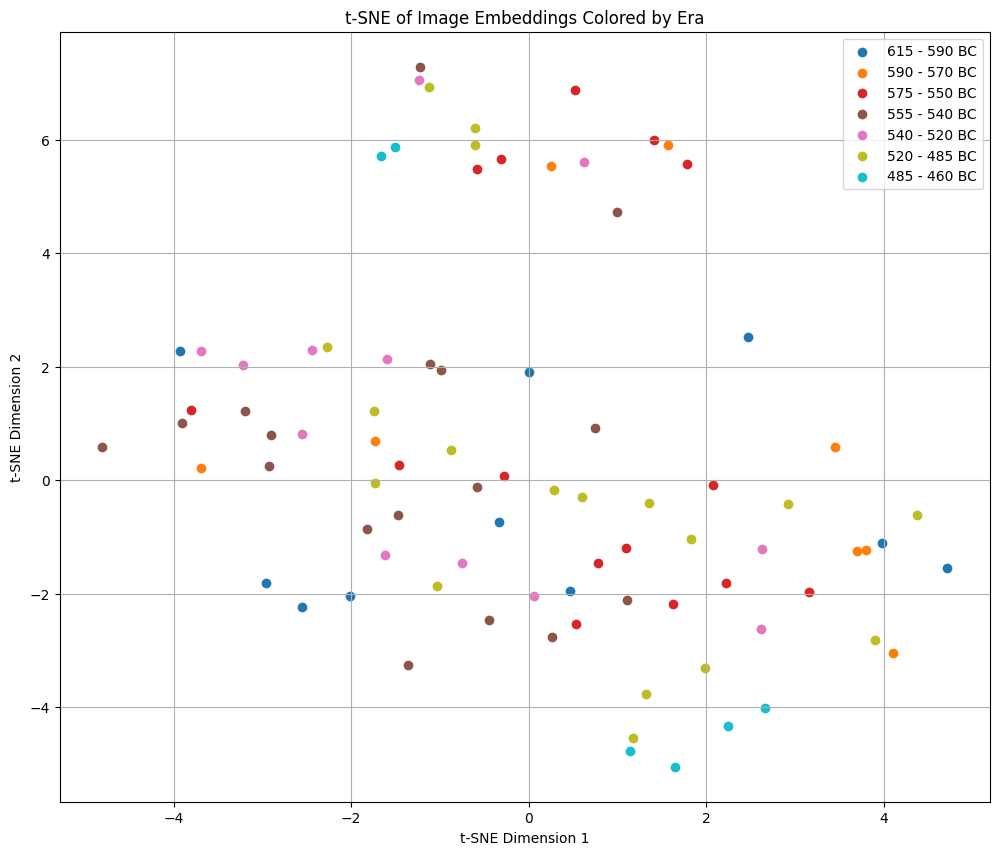

In [6]:
# Proceed with your t-SNE and plotting code...
tsne = TSNE(n_components=2, init='pca', method='exact')
tsne_embeddings = tsne.fit_transform(embeddings)

plt.figure(figsize=(12, 10))
unique_eras = df['era'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_eras))

for i, era in enumerate(unique_eras):
    indices = df[df['era'] == era].index
    plt.scatter(tsne_embeddings[indices, 0], tsne_embeddings[indices, 1], color=colors(i), label=era)

plt.title('t-SNE of Image Embeddings Colored by Era')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
!pip install plotly==5.14.0 --quiet

In [8]:
import plotly.express as px


In [9]:
# Create a DataFrame for Plotly
plotly_df = pd.DataFrame({
    'TSNE_Dim1': tsne_embeddings[:, 0],
    'TSNE_Dim2': tsne_embeddings[:, 1],
    'Era': df['era'].tolist(), # Use the 'era' column from your original df
    'Filename': df['filename'].tolist() # Include the filenames
})
fig = px.scatter(
        plotly_df,
        x='TSNE_Dim1',
        y='TSNE_Dim2',
        color='Era',
        hover_data=['Filename'], # Show filename when hovering
        title='Interactive t-SNE of Image Embeddings Colored by Era'
    )

fig.show()

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:1983: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


C:\Users\Kaiyan Zhang\AppData\Local\Temp\ipykernel_16612\119444610.py:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



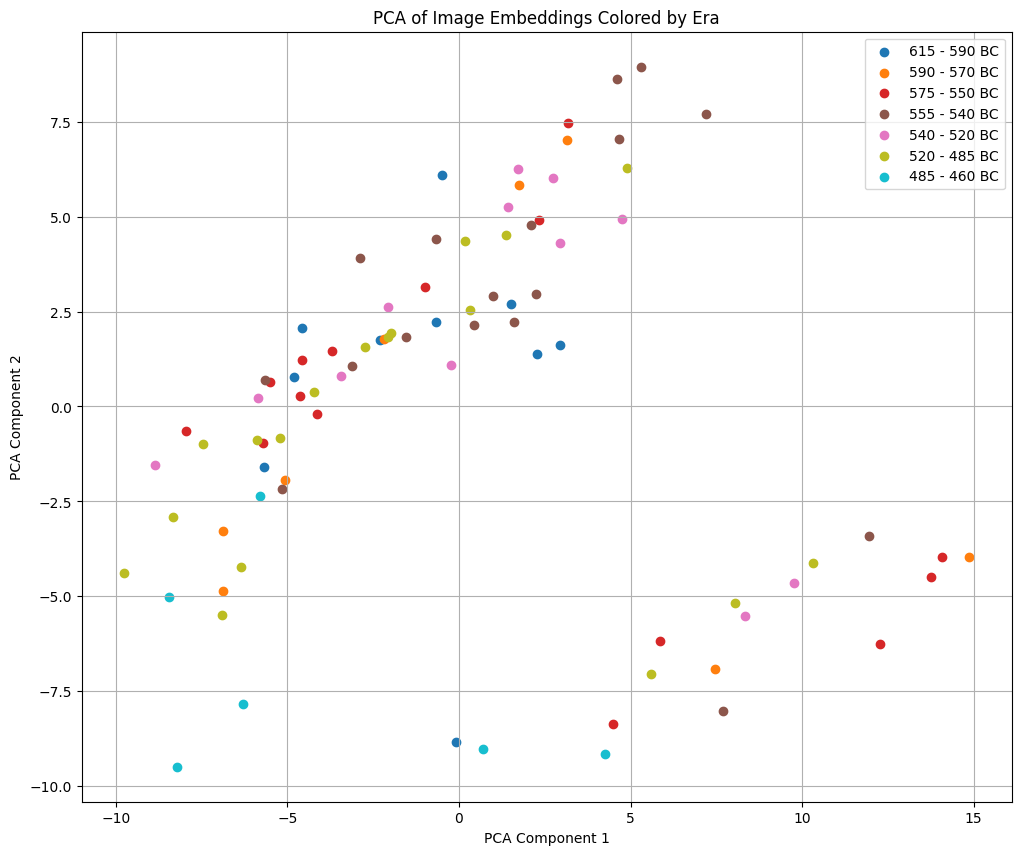

In [10]:
from sklearn.decomposition import PCA

# Perform PCA instead of t-SNE
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

# Plot the PCA result
plt.figure(figsize=(12, 10))
unique_eras = df['era'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_eras))

for i, era in enumerate(unique_eras):
    indices = df[df['era'] == era].index
    plt.scatter(pca_embeddings[indices, 0], pca_embeddings[indices, 1], color=colors(i), label=era)

plt.title('PCA of Image Embeddings Colored by Era')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


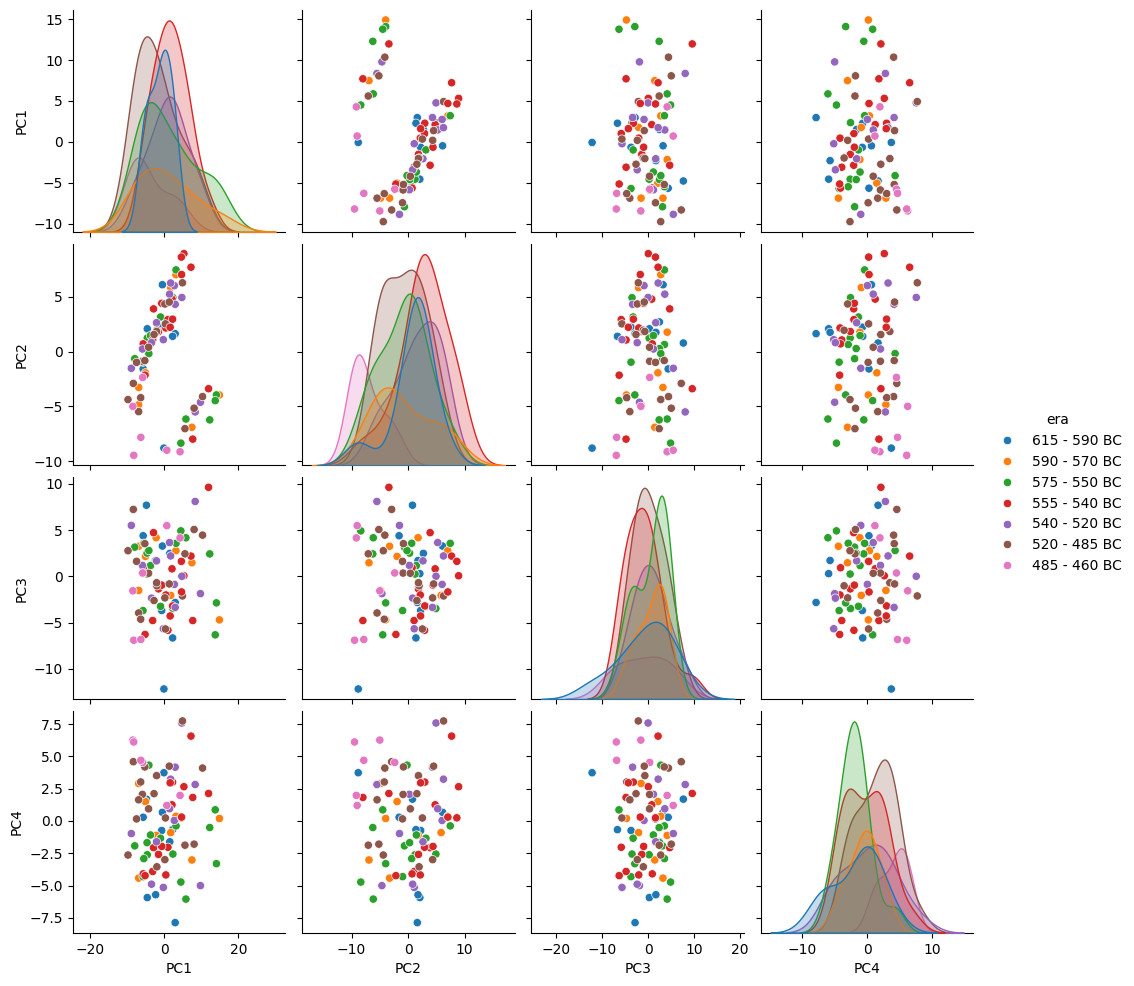

In [12]:
from sklearn.decomposition import PCA

# e.g. compute 5 principal components
pca = PCA(n_components=6)
pca_embeddings = pca.fit_transform(embeddings)
# now pca_embeddings.shape == (n_samples, 5)

pc_df = pd.DataFrame(
    pca_embeddings[:, :6],
    columns=['PC1','PC2','PC3','PC4', 'PC5', 'PC6']
)
pc_df['era'] = df['era'].values

import seaborn as sns
sns.pairplot(pc_df, hue='era', vars=['PC1','PC2','PC3','PC4'])
plt.show()



In [13]:
# Create a DataFrame for Plotly
plotly_df = pd.DataFrame({
    'TSNE_Dim1': pca_embeddings[:, 0],
    'TSNE_Dim2': pca_embeddings[:, 1],
    'Era': df['era'].tolist(), # Use the 'era' column from your original df
    'Filename': df['filename'].tolist() # Include the filenames
})
fig = px.scatter(
        plotly_df,
        x='TSNE_Dim1',
        y='TSNE_Dim2',
        color='Era',
        hover_data=['Filename'], # Show filename when hovering
        title='Interactive t-SNE of Image Embeddings Colored by Era'
    )

fig.show()

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:1983: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Dinov2Model is using Dinov2SdpaSelfAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


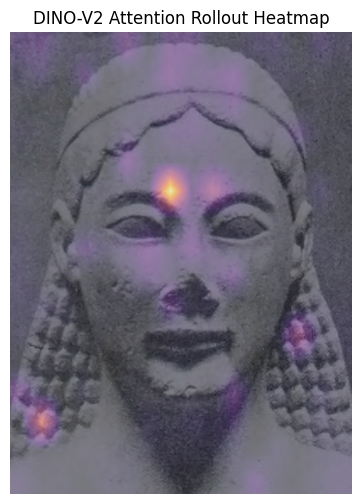

In [15]:
model = Dinov2Model.from_pretrained(
    "facebook/dinov2-base",
    output_attentions=True,   # <-- get all the self-attention weights
).eval().to(device)
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")

img = Image.open("../data/richter_kouroi_head_front_only/page264_img01_photo3.jpg")
inputs = processor(images=img, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

# outputs.attentions: tuple of length L (num layers), each (batch=1, heads=H, seq_len=T, seq_len=T)
attns = [attn[0].mean(dim=0).cpu()  # average over heads
         for attn in outputs.attentions]

T = attns[0].size(-1)  # total tokens = 1 (CLS) + num_patches
rollout = torch.eye(T)

for layer_attn in attns:
    # Add identity (residual) and renormalize rows
    layer_aug = layer_attn + torch.eye(T)
    layer_aug = layer_aug / layer_aug.sum(dim=-1, keepdim=True)
    # Propagate
    rollout = layer_aug @ rollout

# Extract CLS → patch attentions (skip the CLS→CLS token at rollout[0,0])
patch_attn = rollout[0, 1:]  # shape: (num_patches,)

# Reshape to 2D grid
grid_size = int(np.sqrt(patch_attn.size(0)))
heatmap = patch_attn.reshape(grid_size, grid_size).numpy()

heatmap_tensor = torch.tensor(heatmap).unsqueeze(0).unsqueeze(0)  # (1,1,G,G)
heatmap_up = torch.nn.functional.interpolate(
    heatmap_tensor,
    size=img.size[::-1],      # (height, width)
    mode="bilinear",
    align_corners=False
)[0,0].numpy()

plt.figure(figsize=(6,6))
plt.imshow(img, alpha=0.8)
plt.imshow(heatmap_up, cmap="inferno", alpha=0.5)
plt.axis("off")
plt.title("DINO-V2 Attention Rollout Heatmap")
plt.show()
